In [1]:
# import relevant libraries
import boto3
import torch
import sagemaker
import json
import numpy as np
import PIL
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
from torch import nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms

In [2]:
# display version of PyTorch
print(torch.__version__)

2.0.0


In [3]:
import sagemaker

# Start SageMaker session
sagemaker_session = sagemaker.Session()

# Specify S3 bucket and prefix for training and model data
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/car-model'

# Specify the IAM role ARN used to access the training and model data
sagemaker_role_arn = 'arn:aws:iam::121377444070:role/Cloud_Computing'

# Set the IAM role for SageMaker
sagemaker_role = sagemaker_role_arn

# Use the sagemaker_role in your code as needed

### Getting the data

In [4]:
import os

# Specify the directory path
dir_path = os.path.expanduser("~/Desktop/tmp/cars/train")

# Create the directory if it doesn't exist
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

import boto3
import os

# Specify the S3 bucket name and folder path
s3_bucket_name = 'cars-classifiers'
s3_folder_path = 'dataset/archive/cars_train/cars_train/'

# Specify the local destination path
local_path = os.path.expanduser('~/Desktop/tmp/cars/train')

# Create an S3 client
s3_client = boto3.client('s3')

# List objects in the S3 folder using list_objects_v2
paginator = s3_client.get_paginator('list_objects_v2')
operation_parameters = {'Bucket': s3_bucket_name, 'Prefix': s3_folder_path}
page_iterator = paginator.paginate(**operation_parameters)

# Download each object to the local path
for page in page_iterator:
    if 'Contents' in page:
        for s3_object in page['Contents']:
            # Extract the object key and construct the local file path
            s3_object_key = s3_object['Key']
            local_file_path = os.path.join(local_path, os.path.basename(s3_object_key))

            # Download the object to the local file path
            s3_client.download_file(s3_bucket_name, s3_object_key, local_file_path)

            print(f'Downloaded: {s3_object_key} -> {local_file_path}')

#unzip training datasets
#!unzip -o /tmp/cars/cars_train.zip

ClientError: An error occurred (AccessDenied) when calling the ListObjectsV2 operation: Access Denied

In [5]:
import os

# Specify the directory path
dir_path2 = os.path.expanduser("~/Desktop/tmp/cars/test")

# Create the directory if it doesn't exist
if not os.path.exists(dir_path2):
    os.makedirs(dir_path2)

import boto3
import os

# Specify the S3 bucket name and folder path
s3_bucket_name = 'cars-classifiers'
s3_folder_path2 = 'dataset/archive/cars_test/cars_test/'

# Specify the local destination path
local_path2 = os.path.expanduser('~/Desktop/tmp/cars/test')

# Create an S3 client
s3_client = boto3.client('s3')

# List objects in the S3 folder using list_objects_v2
paginator2 = s3_client.get_paginator('list_objects_v2')
operation_parameters2 = {'Bucket': s3_bucket_name, 'Prefix': s3_folder_path}
page_iterator2 = paginator.paginate(**operation_parameters)

# Download each object to the local path
for page in page_iterator:
    if 'Contents' in page:
        for s3_object in page['Contents']:
            # Extract the object key and construct the local file path
            s3_object_key2 = s3_object['Key']
            local_file_path2 = os.path.join(local_path2, os.path.basename(s3_object_key2))

            # Download the object to the local file path
            s3_client.download_file(s3_bucket_name, s3_object_key2, local_file_path2)

            print(f'Downloaded: {s3_object_key2} -> {local_file_path2}')

# unzip test datasets
#!unzip -o /tmp/cars/cars_test.zip

Downloaded: dataset/archive/cars_train/cars_train/08001.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08001.jpg
Downloaded: dataset/archive/cars_train/cars_train/08002.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08002.jpg
Downloaded: dataset/archive/cars_train/cars_train/08003.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08003.jpg
Downloaded: dataset/archive/cars_train/cars_train/08004.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08004.jpg
Downloaded: dataset/archive/cars_train/cars_train/08005.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08005.jpg
Downloaded: dataset/archive/cars_train/cars_train/08006.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08006.jpg
Downloaded: dataset/archive/cars_train/cars_train/08007.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08007.jpg
Downloaded: dataset/archive/cars_train/cars_train/08008.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08008.jpg
Downloaded: dataset/archive/cars_train/cars_trai

Downloaded: dataset/archive/cars_train/cars_train/08071.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08071.jpg
Downloaded: dataset/archive/cars_train/cars_train/08072.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08072.jpg
Downloaded: dataset/archive/cars_train/cars_train/08073.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08073.jpg
Downloaded: dataset/archive/cars_train/cars_train/08074.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08074.jpg
Downloaded: dataset/archive/cars_train/cars_train/08075.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08075.jpg
Downloaded: dataset/archive/cars_train/cars_train/08076.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08076.jpg
Downloaded: dataset/archive/cars_train/cars_train/08077.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08077.jpg
Downloaded: dataset/archive/cars_train/cars_train/08078.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08078.jpg
Downloaded: dataset/archive/cars_train/cars_trai

Downloaded: dataset/archive/cars_train/cars_train/08141.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08141.jpg
Downloaded: dataset/archive/cars_train/cars_train/08142.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08142.jpg
Downloaded: dataset/archive/cars_train/cars_train/08143.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08143.jpg
Downloaded: dataset/archive/cars_train/cars_train/08144.jpg -> /Users/folaranmiadeyeri/Desktop/tmp/cars/test/08144.jpg


In [41]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split
from sklearn.model_selection import train_test_split

class CustomCarDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_file = self.image_files[index]
        image_path = os.path.join(self.root_dir, image_file)
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


local_path3 = os.path.expanduser('~/Desktop/tmp/cars/valid')
dataset_ = CustomCarDataset('/Users/folaranmiadeyeri/Desktop/tmp/cars/train')
dataset__, valid_dataset = train_test_split(dataset_, train_size=0.7, random_state=random_seed)

# Loop through the validation dataset and save each image
for i, image in enumerate(valid_dataset):
    filename = dataset_.image_files[i]
    # Save the image to the output directory with the original filename
    image.save(os.path.join(local_path3, filename))


In [42]:
# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load and transform the datasets with CustomCarDataset
random_seed = 42
train_dataset = CustomCarDataset('/Users/folaranmiadeyeri/Desktop/tmp/cars/train', transform=train_transforms)

valid_dataset = CustomCarDataset('/Users/folaranmiadeyeri/Desktop/tmp/cars/valid', transform=train_transforms)

test_dataset = CustomCarDataset('/Users/folaranmiadeyeri/Desktop/tmp/cars/test', transform=test_transforms)

# Create data loaders
number_of_workers = 0
batch_size = 8

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=number_of_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=number_of_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=number_of_workers)


In [7]:
import scipy.io as sio
import json
import base64
import numpy as np

# Load .mat file
mat_data = sio.loadmat('cars_annos.mat')

# Define custom JSON encoder for NumPy arrays
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

# Convert MATLAB data to Python objects
# Note: mat_data is a dictionary-like object with keys as variable names
# and values as the loaded data
python_data = {}
for key in mat_data:
    # Check if the data is binary (bytes) type
    if isinstance(mat_data[key], bytes):
        # Encode binary data as base64
        python_data[key] = base64.b64encode(mat_data[key]).decode('utf-8')
    else:
        python_data[key] = mat_data[key]

# Convert Python objects to JSON
json_data = json.dumps(python_data, cls=NumpyEncoder)

# Write JSON to file
with open('cat_to_name.json', 'w') as json_file:
    json_file.write(json_data)

In [8]:
# obtain label mapping
!wget -cq https://raw.githubusercontent.com/Follyboy/Cloud_Computing/main/Flower-Image-Classifier-with-Amazon-Sagemaker-master/cat_to_name.json

In [9]:
# display label mapping
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
cat_to_name

{'__header__': 'TUFUTEFCIDUuMCBNQVQtZmlsZSwgUGxhdGZvcm06IEdMTlhBNjQsIENyZWF0ZWQgb246IFNhdCBGZWIgMjggMTk6MzQ6NTUgMjAxNQ==',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': [[[['car_ims/000001.jpg'],
    [[112]],
    [[7]],
    [[853]],
    [[717]],
    [[1]],
    [[0]]],
   [['car_ims/000002.jpg'], [[48]], [[24]], [[441]], [[202]], [[1]], [[0]]],
   [['car_ims/000003.jpg'], [[7]], [[4]], [[277]], [[180]], [[1]], [[0]]],
   [['car_ims/000004.jpg'], [[33]], [[50]], [[197]], [[150]], [[1]], [[0]]],
   [['car_ims/000005.jpg'], [[5]], [[8]], [[83]], [[58]], [[1]], [[0]]],
   [['car_ims/000006.jpg'], [[10]], [[6]], [[250]], [[110]], [[1]], [[0]]],
   [['car_ims/000007.jpg'], [[56]], [[1]], [[394]], [[176]], [[1]], [[0]]],
   [['car_ims/000008.jpg'], [[1]], [[13]], [[113]], [[83]], [[1]], [[0]]],
   [['car_ims/000009.jpg'], [[15]], [[111]], [[271]], [[272]], [[1]], [[0]]],
   [['car_ims/000010.jpg'], [[14]], [[18]], [[148]], [[107]], [[1]], [[0]]],
   [['car_ims/000011.jpg'], [[5]],

In [10]:
# explore images
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=number_of_workers)

# Get some random training images
batch = next(iter(train_loader))
images, labels = batch[0], batch[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


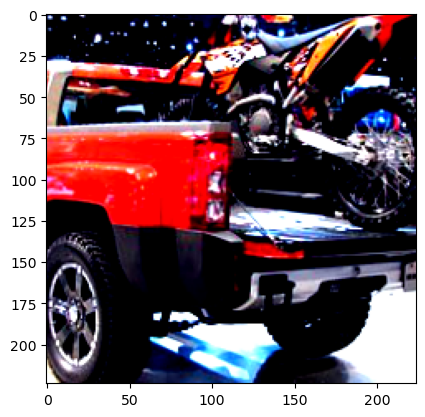

In [11]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.456  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


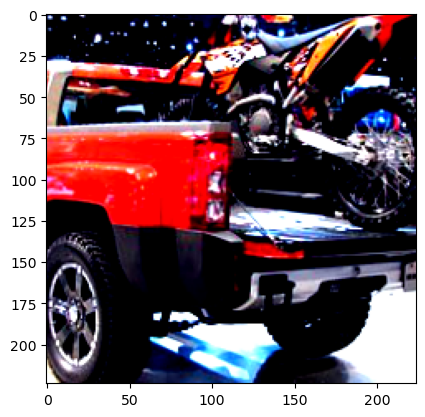

In [12]:
# show images
imshow(torchvision.utils.make_grid(images))

In [43]:
# upload datasets to s3 bucket 
train_input_path   = sagemaker_session.upload_data('/Users/folaranmiadeyeri/Desktop/tmp/cars/train', bucket=bucket, key_prefix=prefix+'/train')
valid_input_path = sagemaker_session.upload_data('/Users/folaranmiadeyeri/Desktop/tmp/cars/valid', bucket=bucket, key_prefix=prefix+'/valid')
test_input_path = sagemaker_session.upload_data('/Users/folaranmiadeyeri/Desktop/tmp/cars/test', bucket=bucket, key_prefix=prefix+'/test')

## Training

In [27]:
print(bucket)

sagemaker-us-east-1-228535841440


In [ ]:
# Define the S3 location for the model output
# model_output_location = f's3://{bucket}/{prefix}/output'

# # Create a SageMaker estimator
# from sagemaker.estimator import Estimator

# py_estimator = Estimator(
#     entry_point='pytorch-cnn-1.py',
#     role=sagemaker_role,
#     image_uri=f's3://{bucket}/{prefix}', # Specify the custom container image URI
#     instance_count=1,
#     instance_type='ml.p2.xlarge',
#     hyperparameters={
#         'epochs': 5,
#         'lr': 0.01,
#         'backend': 'gloo'
#     },
#     framework_version='0.4.0',
#     py_version='py3',
#     output_path=model_output_location # Pass the S3 output path to the estimator
# )
from sagemaker.pytorch import PyTorch

py_estimator = PyTorch(entry_point='pytorch-cnn-1.py',
                    role=sagemaker_role,
                    framework_version='0.4.0',
                    py_version='py3',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 5,
                        'lr' : 0.01,
                        'backend': 'gloo'
                    })


In [ ]:
# import torch
# from sagemaker.pytorch import PyTorch

# # Set the S3 location for the training and validation data
# train_input = f's3://{bucket}/{prefix}/training' #Fola, update the location of the bucket we want to upload the training data on S3
# valid_input = f's3://{bucket}/{prefix}/validation' #Fola, update the location of the bucket we want to upload the test data on S3

# # Create a PyTorch Estimator object
# py_estimator = PyTorch(
#     entry_point='your_entry_point.py',
#     source_dir='your_source_directory',
#     role=sagemaker_role,
#     framework_version='0.4.0',
#     instance_count=1,
#     instance_type='ml.p2.xlarge',
# )

# Start the training job
py_estimator.fit({'training': train_input_path, 'validation': valid_input_path})

## Inference

In [ ]:
#FROM HERE DOWN NOT REQUIRED AS WE HAVE TO DEMO
# Deploy the PyTorch model to a SageMaker endpoint 
predictor = py_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    endpoint_name='your_endpoint_name' #Update with Sagemaker endpoint name
)

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    model.to(device)
    model.eval()
    image = process_image(image_path).unsqueeze_(0)
    output = model(image.to(device)) / 100
    output = output.float().cpu()
    return torch.topk(output, topk)

In [ ]:
def plot_probs(names, values):
    
    # Horizontal plot adapted from Matplotlib documentation
    # https://matplotlib.org/gallery/lines_bars_and_markers/barh.html
    plt.rcdefaults()
    fig, ax = plt.subplots()
    
    y_pos = np.arange(len(names))
    
    ax.barh(y_pos, values, color='blue', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names)
    ax.invert_yaxis()
    
    plt.show()

In [ ]:
# TODO: Display an image along with the top 5 classes
image = (test + '/73/' + 'image_00258.jpg' )
imshow(process_image(image2).numpy())
plot_probs(flower_names, flower_probs)

<img src="pic1.JPG">

<img src="pic2.JPG">